# Strava Training Data Analysis

Data Analysis and Data Visualization of Running, Cycling and Other Activities in Strava

NOTE: To use, first run [strava_downloader.ipynb](https://github.com/markwk/qs_ledger/blob/master/strava/strava_downloader.ipynb) to download your strava data.

-----

## Dependencies

In [1]:
from datetime import date, datetime as dt, timedelta as td
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

----

### Import Data

In [2]:
# unread articles
strava = pd.read_csv('data/strava-activities-raw.csv')

In [3]:
strava.columns = ['timestamp', 'resource_state', 'athlete', 'name', 'distance',
       'moving_time', 'elapsed_time', 'total_elevation_gain', 'type',
       'workout_type', 'id', 'external_id', 'upload_id', 'start_date',
       'start_date_local', 'timezone', 'utc_offset', 'start_latlng',
       'end_latlng', 'location_city', 'location_state', 'location_country',
       'start_latitude', 'start_longitude', 'achievement_count', 'kudos_count',
       'comment_count', 'athlete_count', 'photo_count', 'map', 'trainer',
       'commute', 'manual', 'private', 'visibility', 'flagged', 'gear_id',
       'from_accepted_tag', 'average_speed', 'max_speed', 'has_heartrate',
       'average_heartrate', 'max_heartrate', 'heartrate_opt_out',
       'display_hide_heartrate_option', 'elev_high', 'elev_low', 'pr_count',
       'total_photo_count', 'has_kudoed', 'average_watts', 'kilojoules',
       'device_watts', 'average_cadence']

In [4]:
print("===== Strava Activity Counts =====")
for type in strava.type.unique():
    count = len(strava[strava.type == type])
    print('{:,} total {} activtiies'.format(count, type))

===== Strava Activity Counts =====
63 total Ride activtiies
562 total Run activtiies
113 total Walk activtiies
4 total Swim activtiies
90 total WeightTraining activtiies
1 total Hike activtiies


In [5]:
print("===== Strava Activity Total Distances =====")
for type in strava.type.unique():
    distance = round(strava[strava.type == type]['distance'].sum(),2)
    print('{:,} kms for {}'.format(distance, type))

===== Strava Activity Total Distances =====
446,575.2 kms for Ride
4,475,312.3 kms for Run
209,247.2 kms for Walk
2,546.4 kms for Swim
0.0 kms for WeightTraining
975.6 kms for Hike


----

## Strava: Data Processing

In [6]:
# convert with pd.to_datetime
strava['timestamp'] = pd.to_datetime(strava['timestamp'])
strava['start_date'] = pd.to_datetime(strava['start_date'])

# date additions of time_added
strava['date'] = strava['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d')) # note: not very efficient
strava['year'] = strava['timestamp'].dt.year
strava['month'] = strava['timestamp'].dt.month
strava['mnth_yr'] = strava['timestamp'].apply(lambda x: x.strftime('%Y-%m')) # note: not very efficient
strava['day'] = strava['timestamp'].dt.day
strava['dow'] = strava['timestamp'].dt.weekday
strava['hour'] = strava['timestamp'].dt.hour

In [7]:
# Generate Range of Dates from First Run added to Today
first_date = strava['date'].head(1).values[0]
last_date = strava['date'].tail(1).values[0]
all_dates = pd.date_range(start=first_date, end=last_date)
all_dates = pd.DataFrame(all_dates, columns=['date'])

In [8]:
# Total Activites / Days
perc_activities = round(len(strava) / len(all_dates), 2)
perc_activities

0.81

---

# Strava Run Training Data Analysis

In [9]:
runs = strava[strava.type == 'Run']

### Daily Running

In [10]:
run_dist = runs.groupby(['date'])['distance'].sum().reset_index(name='distance')

# convert with pd.to_datetime
run_dist['date'] = pd.to_datetime(run_dist['date'])

In [11]:
# combine actual runs by date with total dates possible
run_distance_per_date = pd.merge(left=all_dates, right=run_dist, 
                                 left_on="date", right_on="date", how="outer")
run_distance_per_date['distance'].fillna(0, inplace=True)

In [12]:
run_distance_per_date['km'] = run_distance_per_date['distance'] / 1000

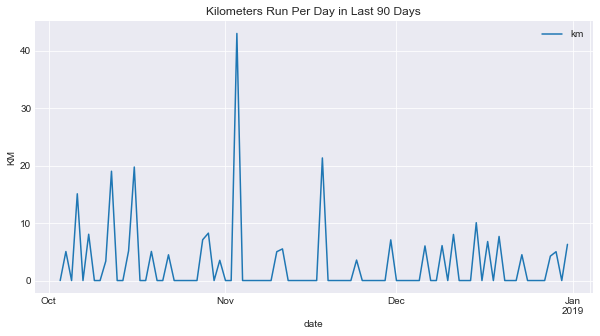

In [13]:
dataset = run_distance_per_date.tail(90)

chart_title = 'Kilometers Run Per Day in Last 90 Days'
plt.style.use('seaborn-darkgrid')

ax = dataset.plot(x="date", y='km', figsize=(10, 5))
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('KM')
ax.set_title(chart_title)
plt.show()

### Daily Rolling Mean of Running

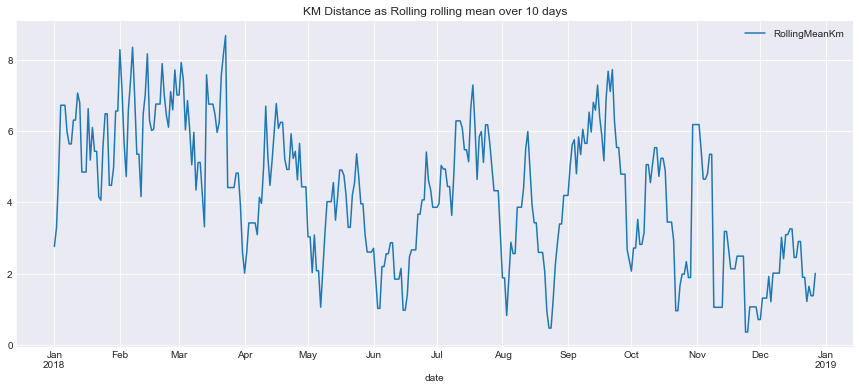

In [14]:
run_distance_per_date['RollingMeanKm'] = run_distance_per_date.km.rolling(window=10, center=True).mean()
plt.style.use('seaborn-darkgrid')
run_distance_per_date.tail(365).plot(x='date', y='RollingMeanKm', 
                           title= 'KM Distance as Rolling rolling mean over 10 days', 
                           figsize=[15, 6])

### Monthly Distance

In [15]:
run_month = runs.groupby(['mnth_yr'])['distance'].sum().reset_index(name='distance')
# convert with pd.to_datetime
run_month['mnth_yr'] = pd.to_datetime(run_month['mnth_yr'])
run_month['km'] = run_month['distance'] / 1000

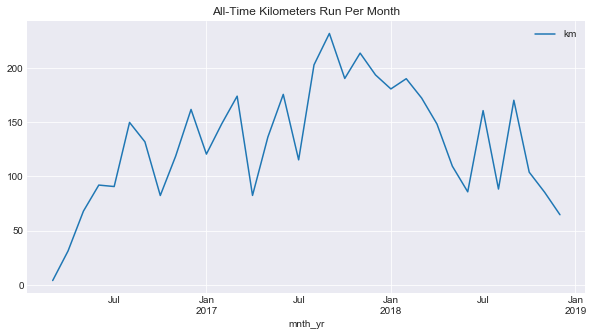

In [16]:
dataset = run_month
chart_title = 'All-Time Kilometers Run Per Month'
plt.style.use('seaborn-darkgrid')
ax = dataset.plot(x="mnth_yr", y='km', figsize=(10, 5))
ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('KM')
ax.set_ylabel('')
ax.set_title(chart_title)
plt.show()

----

# Year in Review Data Analysis

In [17]:
# Set Year and Workout Type:
target_year = 2018
# Examples: 'Ride', 'Run', 'Walk', 'Swim', 'WeightTraining', 'Hike'
target_type = 'Run'

## Activity Summary

In [18]:
def yearly_summary(year, workout_type):    
    # Data Setup
    year_data = strava[(strava['year'] == year) & (strava.type == workout_type)].copy()
    
    # data preparations
    year_data['km'] = round(year_data['distance'] / 1000, 2)
      
    print('====== {} {} Summary ====== '.format(year, workout_type))
    print('Total Number of {} Workouts: {:,}'.format(workout_type, len(year_data)))
    print('Total {} Distance: {:,} kms'.format(workout_type, round(year_data['km'].sum(),2)))
    print('Total {} Elevation Gain: {:,} kms'.format(workout_type, round(year_data['total_elevation_gain'].sum() / 1000,2)))
    print(' ') 
    
    average_run_distance = round(year_data['km'].mean(),1)
    print('Average {} Run Distance: {:,} kms'.format(workout_type, average_run_distance))
    average_run_time = round(year_data['elapsed_time'].mean() / 60,1)
    print('Average {} Workout Time: {:,} minutes'.format(workout_type, average_run_time))
    average_run_speed = round(year_data['average_speed'].mean() * 3.6, 2)
    print('Average {} Workout Speed: {:,} km/h'.format(workout_type, average_run_speed))
    print(' ')
   
    print('Fastest {} Workouts:'.format(workout_type))
    for index, row in year_data.sort_values(by=['average_speed'], ascending=False).head(5).iterrows():
        runtime = round(row['elapsed_time'] / 60, 1)
        speed = round(row['average_speed'] * 3.6, 2) # m/s to km/h
        print("* " + str(speed) + "km/h on " + row["date"] +" for "+ str(row["km"]) + "km " + str(runtime) + "min")
    print(' ')
    
    print('Longest {} Workouts:'.format(workout_type))
    for index, row in year_data.sort_values(by=['distance'], ascending=False).head(5).iterrows():
        runtime = round(row['elapsed_time'] / 60/60, 1)
        print("* " + str(row["km"]) + " km: " + row["name"] + " on " + row["date"] + " in " + str(runtime) + "h")   

In [19]:
yearly_summary(year=target_year, workout_type=target_type)

====== 2018 Run Summary ====== 
Total Number of Run Workouts: 176
Total Run Distance: 1,559.72 kms
Total Run Elevation Gain: 15.73 kms
 
Average Run Run Distance: 8.9 kms
Average Run Workout Time: 54.2 minutes
Average Run Workout Speed: 10.07 km/h
 
Fastest Run Workouts:
* 14.88km/h on 2018-05-26 for 2.1km 8.4min
* 12.73km/h on 2018-05-22 for 0.86km 4.2min
* 12.26km/h on 2018-02-15 for 5.32km 26.1min
* 11.97km/h on 2018-02-20 for 5.13km 25.7min
* 11.93km/h on 2018-03-01 for 7.49km 38.2min
 
Longest Run Workouts:
* 42.98 km: Xichang Marathon (cramps!)  on 2018-11-03 in 5.2h
* 42.68 km: Dujiangyan Marathon on 2018-03-18 in 4.5h
* 23.02 km: Afternoon Run on 2018-02-16 in 2.1h
* 21.33 km: Wenjiang Half Marathon on 2018-11-18 in 2.1h
* 21.23 km: Afternoon Run on 2018-03-03 in 2.0h


## Daily Running Distance as a Heatmap Calendar

In [20]:
# Helper Function to Create Heat Map from Data
# Adapted from https://stackoverflow.com/questions/32485907/matplotlib-and-numpy-create-a-calendar-heatmap
DAYS = ['Sun.', 'Mon.', 'Tues.', 'Wed.', 'Thurs.', 'Fri.', 'Sat.']
MONTHS = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']


def date_heatmap(series, start=None, end=None, mean=False, ax=None, **kwargs):
    '''Plot a calendar heatmap given a datetime series.

    Arguments:
        series (pd.Series):
            A series of numeric values with a datetime index. Values occurring
            on the same day are combined by sum.
        start (Any):
            The first day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            earliest date in the data.
        end (Any):
            The last day to be considered in the plot. The value can be
            anything accepted by :func:`pandas.to_datetime`. The default is the
            latest date in the data.
        mean (bool):
            Combine values occurring on the same day by mean instead of sum.
        ax (matplotlib.Axes or None):
            The axes on which to draw the heatmap. The default is the current
            axes in the :module:`~matplotlib.pyplot` API.
        **kwargs:
            Forwarded to :meth:`~matplotlib.Axes.pcolormesh` for drawing the
            heatmap.

    Returns:
        matplotlib.collections.Axes:
            The axes on which the heatmap was drawn. This is set as the current
            axes in the `~matplotlib.pyplot` API.
    '''
    # Combine values occurring on the same day.
    dates = series.index.floor('D')
    group = series.groupby(dates)
    series = group.mean() if mean else group.sum()

    # Parse start/end, defaulting to the min/max of the index.
    start = pd.to_datetime(start or series.index.min())
    end = pd.to_datetime(end or series.index.max())

    # We use [start, end) as a half-open interval below.
    end += np.timedelta64(1, 'D')

    # Get the previous/following Sunday to start/end.
    # Pandas and numpy day-of-week conventions are Monday=0 and Sunday=6.
    start_sun = start - np.timedelta64((start.dayofweek + 1) % 7, 'D')
    end_sun = end + np.timedelta64(7 - end.dayofweek - 1, 'D')

    # Create the heatmap and track ticks.
    num_weeks = (end_sun - start_sun).days // 7
    heatmap = np.zeros((7, num_weeks))
    ticks = {}  # week number -> month name
    for week in range(num_weeks):
        for day in range(7):
            date = start_sun + np.timedelta64(7 * week + day, 'D')
            if date.day == 1:
                ticks[week] = MONTHS[date.month - 1]
            if date.dayofyear == 1:
                ticks[week] += f'\n{date.year}'
            if start <= date < end:
                heatmap[day, week] = series.get(date, 0)

    # Get the coordinates, offset by 0.5 to align the ticks.
    y = np.arange(8) - 0.5
    x = np.arange(num_weeks + 1) - 0.5

    # Plot the heatmap. Prefer pcolormesh over imshow so that the figure can be
    # vectorized when saved to a compatible format. We must invert the axis for
    # pcolormesh, but not for imshow, so that it reads top-bottom, left-right.
    ax = ax or plt.gca()
    mesh = ax.pcolormesh(x, y, heatmap, **kwargs)
    ax.invert_yaxis()

    # Set the ticks.
    ax.set_xticks(list(ticks.keys()))
    ax.set_xticklabels(list(ticks.values()))
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(DAYS)

    # Set the current image and axes in the pyplot API.
    plt.sca(ax)
    plt.sci(mesh)

    return ax

In [21]:
def year_heat_chart(year, workout_type, type='training'):    
    # Data Setup
    year_data = strava[(strava['year'] == year) & (strava.type == workout_type)]
    # segment by type
    if type == 'all':
        pass
    elif type == 'training':
        # TODO: Is there a way to get if it is a race from data in API? 
        year_data = year_data[year_data['name'].str.contains('Race|Marathon|Half|21k', regex=True) == False]
    else:
        year_data = year_data[year_data['name'].str.contains('Race|Marathon|Half|21k', regex=True) == True]
    
    year_dates_data = year_data.groupby(['date'])['distance'].sum().reset_index(name='distance')
    year_dates_data['date'] = pd.to_datetime(year_dates_data['date'])
    
    # Generate all dates in that year
    first_date = str(year)+'-01-01'#runs_2018_dist['date'].head(1).values[0]
    last_date = str(year)+'-12-31'#runs_2018_dist['date'].tail(1).values[0]
    all_dates = pd.date_range(start=first_date, end=last_date)
    all_dates = pd.DataFrame(all_dates, columns=['date'])
    
    # combine actual runs by date with total dates possible
    year_data = pd.merge(left=all_dates, right=year_dates_data, 
                                 left_on="date", right_on="date", how="outer")
    year_data['distance'].fillna(0, inplace=True)
    year_data = year_data.set_index(pd.DatetimeIndex(year_data['date']))
    year_data['km'] = round(year_data['distance'] / 1000, 2)
    
    max_daily_distance = round(year_data['km'].max(),0)
    
    # key stat and title
    total_distance = round(year_data['km'].sum(),2)
    chart_title = '{} {} {} activites | Total Distance {:,} kms'.format(year, workout_type, type, total_distance)
    
    # set chart data
    data = pd.Series(year_data.km)
    data.index = year_data.index 
    
    # plot data
    figsize = plt.figaspect(7 / 56)
    fig = plt.figure(figsize=figsize)
    ax = date_heatmap(data, edgecolor='black')
    max_dist = int(round(data.max(),0))
    steps = int(round(max_dist / 6, 0))
    plt.colorbar(ticks=range(0, max_dist, steps), pad=0.02)
    cmap = mpl.cm.get_cmap('Reds', max_daily_distance)
    plt.set_cmap(cmap)
    plt.clim(0, max_daily_distance)
    ax.set_aspect('equal')
    ax.set_title(chart_title)
    plt.show()

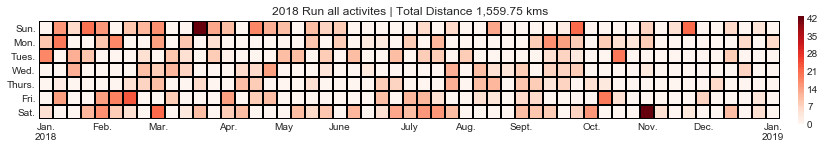

In [22]:
year_heat_chart(year=target_year, workout_type=target_type, type='all')

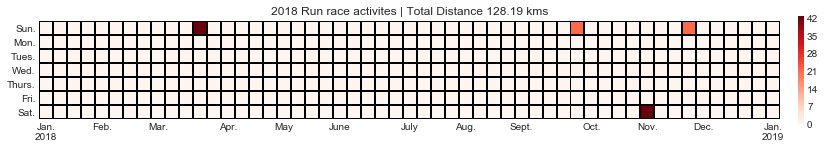

In [23]:
year_heat_chart(year=target_year, workout_type=target_type, type='race')

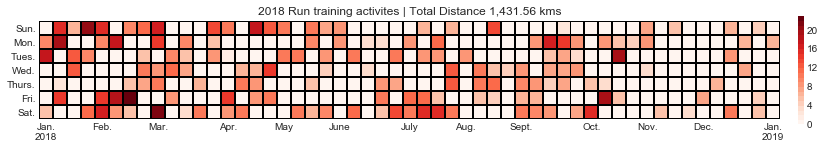

In [24]:
year_heat_chart(year=target_year, workout_type=target_type, type='training')

## Monthly Running

In [25]:
def yearly_month_stats(year, workout_type='Run'):
    print('====== {} {} Monthly Breakdown ====== '.format(year, workout_type))
    yearly_month_data = strava[(strava['year'] == year) & (strava.type == workout_type)]

    yearly_month = yearly_month_data.groupby(['mnth_yr'])['distance'].sum().reset_index(name='distance')
    yearly_month['km'] = yearly_month['distance'] / 1000
    
    average_monthly_distance = round(yearly_month['km'].mean() ,1)
    print('Average Monthly Distance: {:,} kms'.format(average_monthly_distance))
    
    monthly_max = yearly_month[yearly_month['km'] == yearly_month['km'].max()]
    print("{:,} Monthly Max in {}".format(round(monthly_max.km.item(),2), monthly_max.mnth_yr.item()))
    monthly_min = yearly_month[yearly_month['km'] == yearly_month['km'].min()]
    print("{:,} Monthly Min in {}".format(round(monthly_min.km.item(),2), monthly_min.mnth_yr.item()))

In [26]:
def yearly_month_chart(year, workout_type='Run'):
    
    yearly_month_data = strava[(strava['year'] == year) & (strava.type == workout_type)]

    yearly_month = yearly_month_data.groupby(['mnth_yr'])['distance'].sum().reset_index(name='distance')
    yearly_month['km'] = yearly_month['distance'] / 1000

    dataset = yearly_month
    chart_title = '{} Monthly {} Distance'.format(year, workout_type)

    plt.style.use('seaborn-darkgrid')
    ax = dataset.plot.bar(x='mnth_yr', y='km', rot=60, figsize=(10, 5), colormap='winter')
    ax.set_ylabel('KM')
    ax.set_xlabel('')

    ax.set_title(chart_title)
    plt.show()

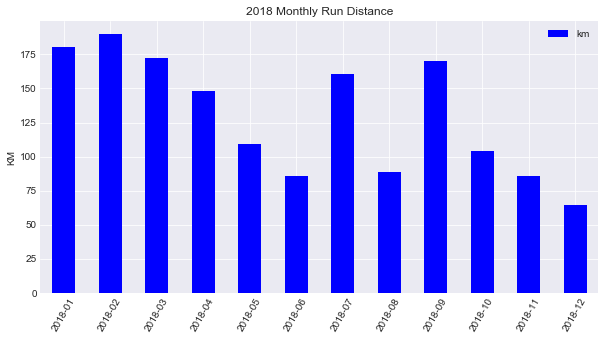

In [27]:
yearly_month_chart(year=target_year, workout_type=target_type)